Here I am able to sample through the parameter space and look at which parameters matter in this latency issue. The spearman regression confirms the important variables to consider. Will probably use for figure

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import sys
import pickle
from pyDOE import *
from scipy.stats.distributions import norm

In [2]:
u_N = .005
u_SCM = .005
u_TM = 0.32
u_CM = 0.35
u_EM = 0.30
u_EMRA = 0.005
std = 0.1
u_T = [u_N, u_SCM, u_TM, u_CM, u_EM,u_EMRA]

u_d_ALL = 0.003
u_w = 1/20
u_LRA = 1
u_d = 1
std_param = 1
u_param = [ u_d_ALL, u_w, u_LRA, u_d]

In [9]:
sims = 10000
design = lhs(10, samples=sims)
means = u_T + u_param
stdvs = [10**-10] +[std]*5 + [std_param]*4
for i in range(10):
    design[:, i] = norm(loc=means[i], scale=stdvs[i]).ppf(design[:, i])
design = abs(design)

In [10]:
parameter_arr = np.zeros([sims, 16])
for i in range(6):
    parameter_arr[:,i*2] = design[:,i]
for i in range(6,10):
    parameter_arr[:,i+6] = design[:,i]

In [11]:
# Set plotting parameters
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)

## Define Model

In [12]:
#Define the model
def model(z,t):
    L_n = z[0]
    L_scm = z[2]
    L_tm = z[4]
    L_cm = z[6] 
    L_em = z[8]
    L_emra = z[10]
    
    A_n = z[1]
    A_scm = z[3]
    A_tm = z[5]
    A_cm = z[7]
    A_em = z[9]
    A_emra = z[11]
    
    
    #for drug dosings
    dL_ndt = (p_n - d_n)*L_n - a*L_n + w*A_n
    dA_ndt = a*L_n - d_ALL*A_n - w*A_n
    
    dL_scmdt = (p_scm - d_scm)*L_scm - a*L_scm + w*A_scm
    dA_scmdt = a*L_scm - d_ALL*A_scm - w*A_scm
    
    dL_tmdt = (p_tm - d_tm)*L_tm - a*L_tm + w*A_tm
    dA_tmdt = a*L_tm - d_ALL*A_tm - w*A_tm
    
    dL_cmdt = (p_cm - d_cm)*L_cm - a*L_cm + w*A_cm
    dA_cmdt = a*L_cm - d_ALL*A_cm - w*A_cm
    
    dL_emdt = (p_em - d_em)*L_em - a*L_em + w*A_em
    dA_emdt = a*L_em - d_ALL*A_em - w*A_em
    
    dL_emradt = (p_emra - d_emra)*L_emra - a*L_emra + w*A_emra
    dA_emradt = a*L_emra - d_ALL*A_emra - w*A_emra
    
    
    dzdt = [dL_ndt,dA_ndt,
            dL_scmdt,dA_scmdt,
            dL_tmdt,dA_tmdt,
            dL_cmdt,dA_cmdt,
            dL_emdt,dA_emdt,
            dL_emradt,dA_emradt
            ]
    return dzdt

In [13]:
#number of time points
tn = 2000

#store solutions
#store solutions
L_n = np.zeros([parameter_arr.shape[0],tn])
L_scm = np.zeros([parameter_arr.shape[0],tn])
L_tm = np.zeros([parameter_arr.shape[0],tn])
L_cm = np.zeros([parameter_arr.shape[0],tn])
L_em = np.zeros([parameter_arr.shape[0],tn])
L_emra = np.zeros([parameter_arr.shape[0],tn])

A_n = np.zeros([parameter_arr.shape[0],tn])
A_scm = np.zeros([parameter_arr.shape[0],tn])
A_tm = np.zeros([parameter_arr.shape[0],tn])
A_cm = np.zeros([parameter_arr.shape[0],tn])
A_em = np.zeros([parameter_arr.shape[0],tn])
A_emra = np.zeros([parameter_arr.shape[0],tn])
Total = np.zeros([parameter_arr.shape[0],tn])




for i,parameter in enumerate(parameter_arr):
#initial conditions, there are three
    w = parameter[13] # In Ke's 2015 paper, it looks like a reasonable assumption is 20-50 days because thats where copies of vRNA start dropping
    d = parameter[15]
    LRA = parameter[14]
    d_ALL = parameter[12]

    p_cm = 0.00075 * d
    p_tm = 0.0006 * d
    p_em = 0.0003 * d
    p_n = 0.000099 * d
    p_scm = 0.00001 * d
    p_emra = 0.00005 * d


    corr_fact = -np.log(1/2)
    d_n = corr_fact * (1/1500)
    d_scm = corr_fact * (1/150)
    d_tm = corr_fact * (1/100)
    d_cm = corr_fact * (1/120)
    d_em = corr_fact * (1/90)
    d_emra = corr_fact * (1/250)
    n = 0.00017
    a = n * LRA

    
    z0 = parameter[:12]*10**6

    #time points
    b = 2000
    tn = 60001
    t = np.linspace(0,tn-1, b)


    #record intial

    L_n[i][0] = z0[0]
    L_scm[i][0] = z0[2]
    L_tm[i][0] = z0[4]
    L_cm[i][0] = z0[6] 
    L_em[i][0] = z0[8]
    L_emra[i][0] =z0[10]

    A_n[i][0] = z0[1]
    A_scm[i][0] = z0[3]
    A_tm[i][0] = z0[5]
    A_cm[i][0] = z0[7]
    A_em[i][0] = z0[9]
    A_emra[i][0] = z0[11]

    Total[i][0] = np.sum(z0)

    #Solve the ODE
    for k in range(1,b):
        tspan = [t[k-1],t[k]]
        # solve for next step
        z = odeint(model,z0,tspan)
        # store solution for plotting

        L_n[i][k] = z[1][0]
        L_scm[i][k] = z[1][2]
        L_tm[i][k] = z[1][4]
        L_cm[i][k] = z[1][6] 
        L_em[i][k] = z[1][8]
        L_emra[i][k] = z[1][10]

        A_n[i][k] = z[1][1]
        A_scm[i][k] = z[1][3]
        A_tm[i][k] = z[1][5]
        A_cm[i][k] = z[1][7]
        A_em[i][k] = z[1][9]
        A_emra[i][k] = z[1][11]


        Total[i][k] =np.sum(z[1])
        z0 = z[1] 
    sys.stdout.write('\r {}'.format(i) )
    
t = t/365
pop_dict = {}
pop_dict['latent'] = [L_n, L_scm, L_tm, L_cm, L_em, L_emra]
pop_dict['active'] = [A_n, A_scm, A_tm, A_cm, A_em, A_emra]
pop_dict['times'] = t
pop_dict['total'] = Total
pop_dict['cell_type'] = ['T_n', 'T_scm', 'T_tm', 'T_cm','T_em', 'T_emra']



 9999

In [34]:
pop_dict['sim'] = design

In [14]:
pickle.dump(pop_dict['total'], open('190503_pop_LHS_TN_Constant.p','wb'))

In [35]:
pickle.dump(pop_dict['sim'], open('190503_pop_LHS_TN_Constant_sim_init.p','wb'))

In [17]:
hy_arr = np.zeros([sims])
for i in range(10000):
    a = np.where(pop_dict['total'][i] < 10**2)[0]
    if len(a)== 0:
        hy_arr[i] = 0
    else:
        hy_arr[i] = t[a[0]]

(1, 100)

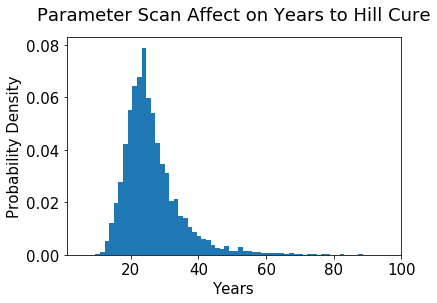

In [19]:
sim_50k = plt.hist(hy_arr, bins = 100, density = True)
plt.xlabel('Years')
plt.ylabel('Probability Density')
plt.title('Parameter Scan Affect on Years to Hill Cure', y = 1.05)
plt.xlim([1,100])

In [20]:
tot_arr = np.zeros([sims])
for i in range(10000):
    a = np.where(pop_dict['total'][i] < 1)[0]
    if len(a)== 0:
        tot_arr[i] = 0
    else:
        tot_arr[i] = t[a[0]]

(1, 200)

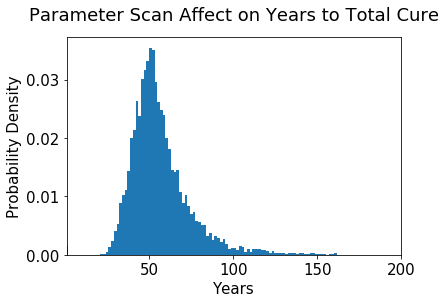

In [21]:
sterile_50k = plt.hist(tot_arr, bins = 100, density = True)
plt.xlabel('Years')
plt.ylabel('Probability Density')
plt.title('Parameter Scan Affect on Years to Total Cure', y = 1.05)
plt.xlim([1,200])

(0, 150)

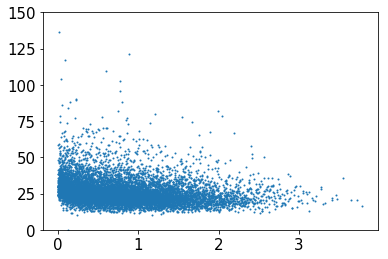

In [22]:
plt.scatter(parameter_arr.T[12], hy_arr, s = 1)
plt.ylim([0,150])

In [23]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr

In [24]:
cure = {}
cure['hy'] = hy_arr
cure['tot'] = tot_arr
pickle.dump(cure, open('190502_cure.p', 'wb'))

In [25]:
spr_corr = spearmanr(design,hy_arr)

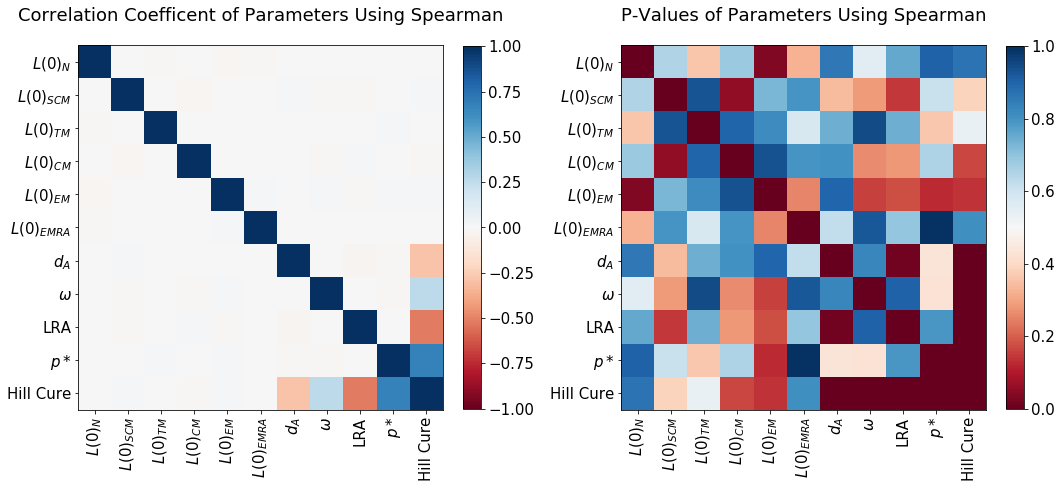

In [26]:
label_param = [r'$L(0)_N$', r'$L(0)_{SCM}$', r'$L(0)_{TM}$',r'$L(0)_{CM}$',r'$L(0)_{EM}$',r'$L(0)_{EMRA}$',r'$d_A$', r'$\omega$', 'LRA', r'$p*$', 'Hill Cure']
plt.figure(figsize = (15,15))
plt.subplot(121)
plt.title('Correlation Coefficent of Parameters Using Spearman', y= 1.05)
im = plt.imshow(spr_corr[0], cmap = 'RdBu', clim=[-1,1])
plt.xticks(np.linspace(0,10,11), label_param, rotation='vertical')
plt.yticks(np.linspace(0,10,11), label_param, rotation='horizontal')
plt.colorbar(im, fraction = 0.045)

plt.subplot(122)
im_pval = plt.imshow(spr_corr[1], cmap = 'RdBu', clim =[0,1])
plt.title('P-Values of Parameters Using Spearman', y= 1.05)
plt.xticks(np.linspace(0,10,11), label_param, rotation='vertical')
plt.yticks(np.linspace(0,10,11), label_param, rotation='horizontal')
plt.colorbar(im_pval, fraction = 0.045)


plt.tight_layout()

In [27]:
label_param = ['L0_N', 'L0_SCM', 'L0_TM', 'L0_CM', 'L0_EM','L0_EMRA','d_A', 'w', 'LRA', 'p*']

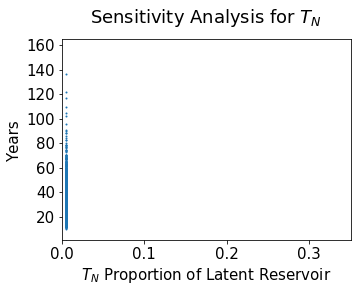

In [28]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize = (7,5))

gs = GridSpec(4,4)

ax_joint = fig.add_subplot(gs[1:4,0:3])
plt.xticks(np.arange(0,1,.1))
plt.yticks(np.arange(20,165,20))
plt.title(r'Sensitivity Analysis for $T_N$', y = 1.05)
plt.xlim([0,0.35])
plt.ylim([1,165])
ax_joint.set_xlabel(r'$T_N$ Proportion of Latent Reservoir' )
ax_joint.set_ylabel('Years')

ax_joint.scatter(design.T[0], hy_arr, s = 1)







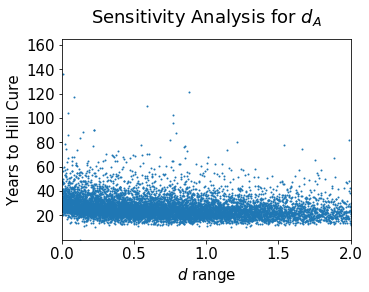

In [29]:

fig = plt.figure(figsize = (7,5))

gs = GridSpec(4,4)

ax_joint = fig.add_subplot(gs[1:4,0:3])
plt.xticks(np.arange(0,5,.5))
plt.yticks(np.arange(20,165,20))
plt.xlim([0,2])
plt.ylim([0,165])
ax_joint.set_xlabel(r'$d$ range')
ax_joint.set_ylabel('Years to Hill Cure')
plt.title(r'Sensitivity Analysis for $d_A$', y = 1.05)


ax_joint.scatter(design.T[6], hy_arr, s = 1)







Text(0, 0.5, 'Years')

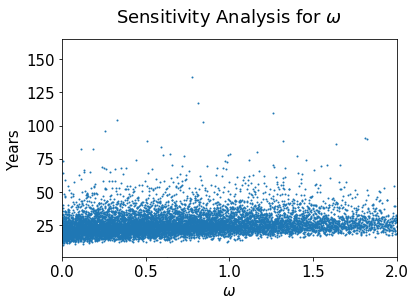

In [30]:
plt.scatter(design.T[7], hy_arr, s = 1)
plt.title(r'Sensitivity Analysis for $\omega$', y = 1.05)
plt.xlim([0,2])
plt.ylim([1,165])
plt.xlabel(r'$\omega$' )
plt.ylabel('Years')

Text(0, 0.5, 'Years')

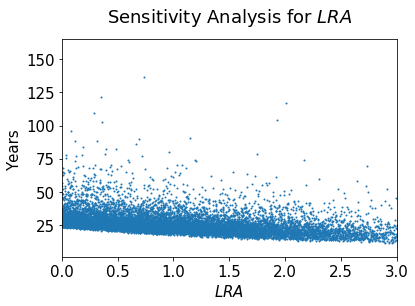

In [31]:
plt.scatter(design.T[8], hy_arr, s = 1)
plt.title(r'Sensitivity Analysis for $LRA$', y = 1.05)
plt.xlim([0,3])
plt.ylim([1,165])
plt.xlabel(r'$LRA$' )
plt.ylabel('Years')

Text(0, 0.5, 'Years')

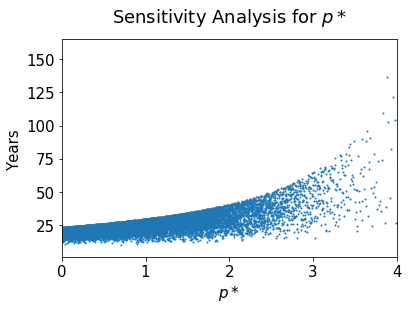

In [32]:
plt.scatter(design.T[9], hy_arr, s = 1)
plt.title(r'Sensitivity Analysis for $p*$', y = 1.05)
plt.xlim([0,4])
plt.ylim([1,165])
plt.xlabel(r'$p*$' )
plt.ylabel('Years')

Text(0, 0.5, 'Years')

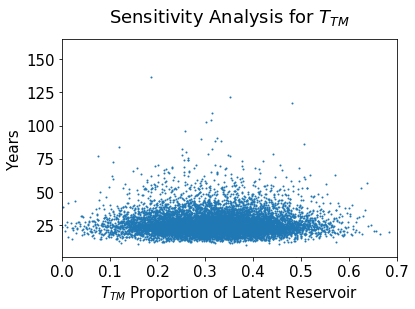

In [33]:
plt.scatter(design.T[2], hy_arr, s = 1)
plt.title(r'Sensitivity Analysis for $T_{TM}$', y = 1.05)
plt.xlim([0,.7])
plt.ylim([1,165])
plt.xlabel(r'$T_{TM}$ Proportion of Latent Reservoir' )
plt.ylabel('Years')